In [63]:
import warnings
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

from time import sleep
from os.path import join
from IPython import display
from sklearn.datasets import load_digits
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, homogeneity_score, completeness_score, v_measure_score # и другие метрики
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

In [2]:
DATA_PATH = "data"
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Реализация Kmeans

5 баллов

В данном задании вам предстоит дописать код класса `MyKMeans`. Мы на простом примере увидим, как подбираются центры кластеров и научимся их визуализировать.

Сгенерируем простой набор данных, 400 объектов и 2 признака (чтобы все быстро работало и можно было легко нарисовать):

In [3]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])

Напишем функцию `visualize_clusters`, которая по данным и меткам кластеров будет рисовать их и разукрашивать:

In [4]:
def visualize_clusters(X, labels):
    """
    Функция для визуализации кластеров
        :param X: таблица объекты х признаки
        :param labels: np.array[n_samples] - номера кластеров
    """
    
    unique_labels = np.sort(np.unique(labels))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, 
                    palette="colorblind", legend=False,
                    hue_order=unique_labels)
    plt.xlabel("$X_1$", fontsize=18)
    plt.ylabel("$X_2$", fontsize=18)
    
    for label in labels:
        center = X[(labels == label)].mean(axis=0)
        plt.scatter(center[0], center[1], s=80, c="#201F12", marker=(5, 2))

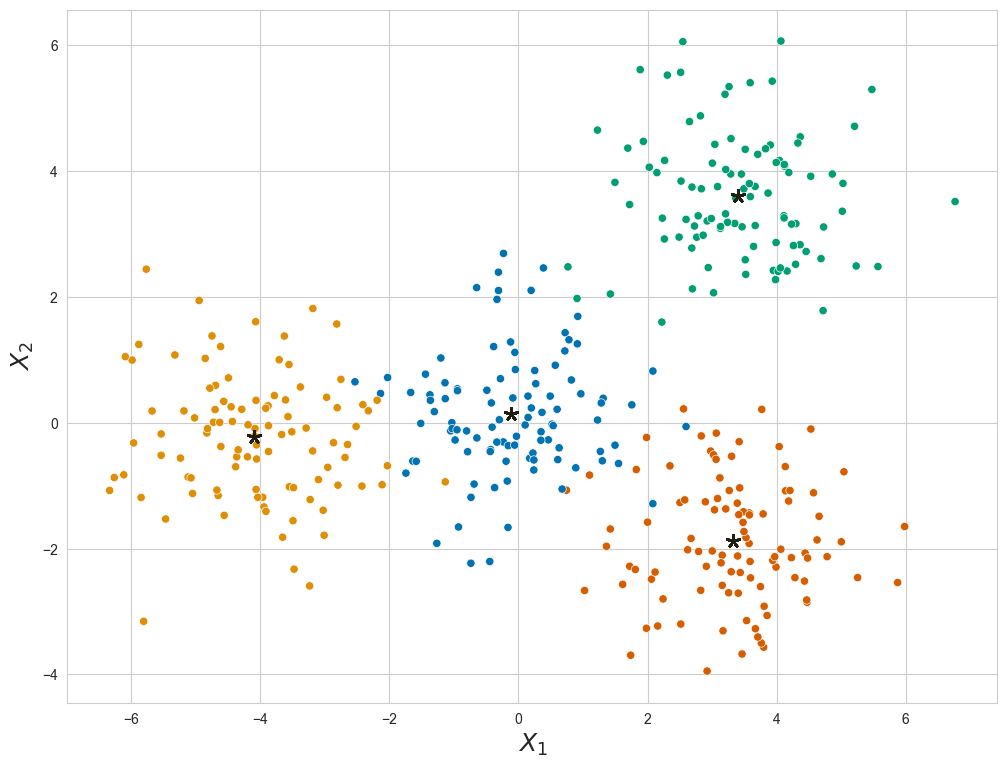

In [5]:
visualize_clusters(X, true_labels)

Напишем свой класс `MyKMeans`, который будет реализовывать алгоритм кластеризации K-средних. Напомним сам алгоритм:

1. Выбераем число кластеров (K)
2. Случайно инициализируем K точек (или выбираем из данных), это будут начальные центры наших кластеров
3. Далее для каждого объекта считаем расстояние до всех кластеров и присваиваем ему метку ближайщего
4. Далее для каждого кластера считаем "центр масс" (среднее значение для каждого признака по всем объектам кластера)
5. Этот "центр масс" становится новым центром кластера
6. Повторяем п.3, 4, 5 заданное число итераций или до сходимости

Во время предсказания алгоритм просто находит ближайщий центроид (центр кластера) для тестового объекта и возвращает его номер.

Реализуйте методы:
* `_calculate_distance(X, centroid)` - вычисляет Евклидово расстояние от всех объектов в `Х` до заданного центра кластера (`centroid`)
* `predict(X)` - для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент

In [6]:
class MyKMeans:
    def __init__(self, n_clusters, init="random", max_iter=300, visualize=False, speed=0.5):
        """
        Конструктор класса MyKMeans
            :param n_clusters: число кластеров
            :param init: способ инициализации центров кластеров
                'random' - генерирует координаты случайно из нормального распределения
                'sample' - выбирает центроиды случайно из объектов выборки
            :param max_iter: заданное число итераций 
                (мы не будем реализовывать другой критерий остановки)
            :param visualize: рисовать ли кластеры и их центроиды в процессе работы
                код будет работать сильно дольше, но красиво...
        """
        
        assert init in ["random", "sample"], f"Неизвестный метод инициализации {init}"
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = None
        self.visualize = visualize
        self.speed = speed
       
    
    def fit(self, X):
        """
        Подбирает оптимальные центры кластеров
            :param X: наши данные (n_samples, n_features)
        :return self: все как в sklearn
        """
        
        n_samples, n_features = X.shape
        
        # Инициализация центров кластеров
        if self.init == "random":
            centroids = np.random.randn(self.n_clusters, n_features)
        elif self.init == "sample":
            centroids_idx = np.random.choice(np.arange(n_samples), 
                                             size=self.n_clusters, 
                                             replace=False)
            centroids = X[centroids_idx]
        
        # Итеративно двигаем центры
        for _ in range(self.max_iter):
            # Посчитаем расстояния для всех объектов до каждого центроида
            dists = []
            for centroid in centroids:
                dists.append(self._calculate_distance(X, centroid))
            dists = np.concatenate(dists, axis=1)
            # Для каждого объекта найдем, к какому центроиду он ближе
            cluster_labels = np.argmin(dists, axis=1)
            
            # Пересчитаем центр масс для каждого кластера
            centroids = []
            for label in np.sort(np.unique(cluster_labels)):
                center = X[(cluster_labels == label)].mean(axis=0)
                centroids.append(center)
            
            # Отрисуем точки, покрасим по меткам кластера, а также изобразим центроиды
            if self.visualize:
                sleep(self.speed)
                visualize_clusters(X, cluster_labels)
                display.clear_output(wait=True)
                display.display(plt.gcf())
                plt.close()
                
        self.centroids = np.array(centroids)
        
        return self
    
    
    def predict(self, X):
        """
        Для каждого X возвращает номер кластера, к которому он относится
            :param X: наши данные (n_samples, n_features)
        :return cluster_labels: метки кластеров
        """
        
        """
        YOUR CODE IS HERE
        """
        dists = []
        for centroid in self.centroids:
            dists.append(self._calculate_distance(X, centroid))
        dists = np.concatenate(dists, axis=1)
        cluster_labels = np.argmin(dists, axis=1)
            
        return cluster_labels
        
        
    def _calculate_distance(self, X, centroid):
        """
        Вычисляет Евклидово расстояние от всех объектов в Х до заданного центра кластера (centroid)
            :param X: наши данные (n_samples, n_features)
            :param centroid: координаты центра кластера
        :return dist: расстояния от всех X до центра кластера
        """
        
        """
        YOUR CODE IS HERE
        """
        dist = np.sqrt(np.sum((X - centroid)**2, axis=1))
        
        return dist.reshape(X.shape[0], 1)
    
    
    def __repr__(self):
        return f"Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*"

Обучите `MyKMeans` на наших игручешных данных, добейтесь сходимости. Не забудьте поставить `visualize=True`, чтобы посмотреть на красивые картинки. Также попробуйте различные способы инициализации центроидов и скажите, какой лучше подошел в этой ситуации.

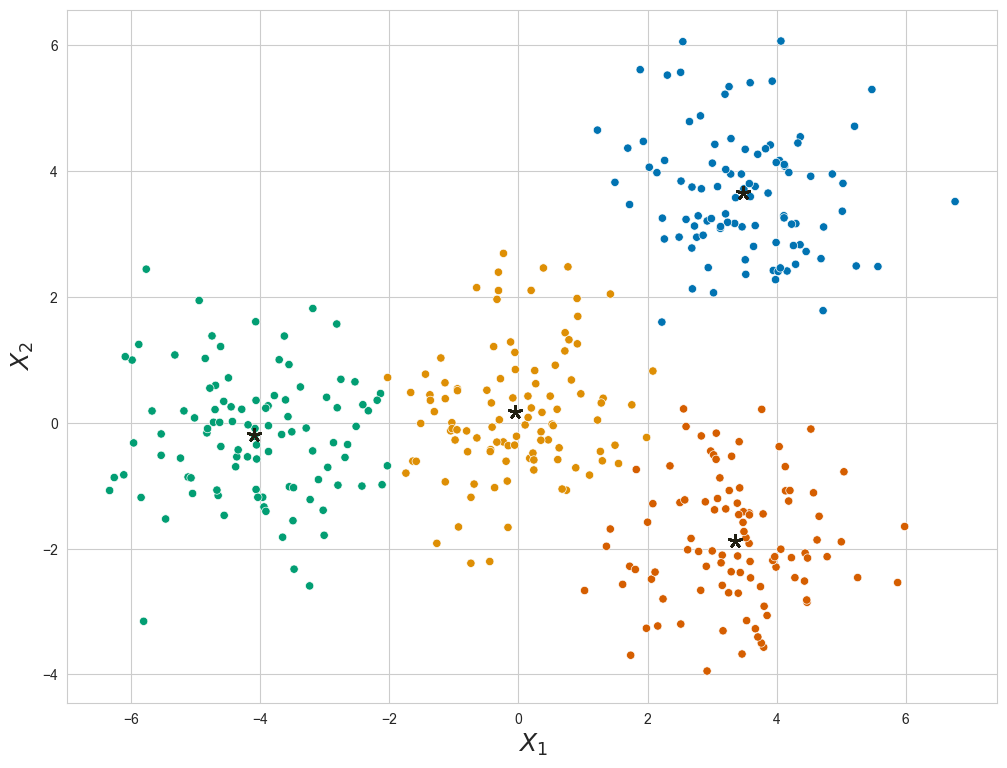

Оценим качество: Силуэт =  0.564


In [7]:
mkm_rand = MyKMeans(4, init="random", max_iter=10, visualize=True, speed=0.1)
mkm_rand.fit(X)
labels_pred_rand = mkm_rand.predict(X)
силуэт_rand = round(silhouette_score(X, labels_pred_rand), 3)
print('Оценим качество: Силуэт = ', силуэт_rand)

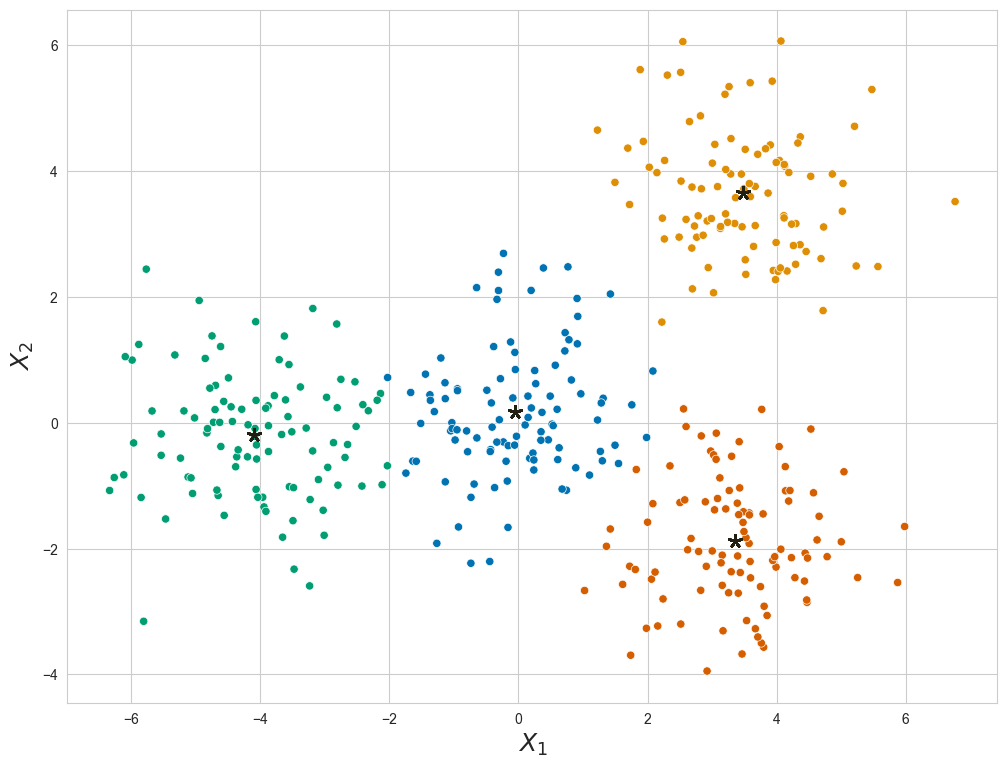

Оценим качество: Силуэт =  0.564


In [8]:
mkm_sample = MyKMeans(4, init="sample", max_iter=10, visualize=True, speed=0.1)
mkm_sample.fit(X)
labels_pred_sample = mkm_sample.predict(X)
силуэт_sample = round(silhouette_score(X, labels_pred_sample), 3)
print('Оценим качество: Силуэт = ', силуэт_sample)

> Так как Силуэт принимает значения от -1 до 1, то в нашем случае результаты достаточно неплохие. На данном игрушечном датасете способы инициализации центроидов не дают особой разницы.

### Задание 2. Подбираем лучшую иерархическую кластеризацию

5 баллов

На лекции были рассмотрены различные расстояния, которые могут служить метриками различия между объектами. Также мы разобрали несколько алгоритмов кластеризации, в том числе и иерархическую. Часто может быть непонятно, какой алгоритм и какую метрику расстояния нужно взять. Давайте упростим себе жизнь и напишем функцию `algorithm_selection`, которая будет на основании переданных ей:

* метрик расстояния (можно брать все, что было на лекциях, минимум 4)
* параметра `linkage` ('average', 'single', 'complete')
* и метрик качества кластеризации ('Homogeneity', 'Completeness', 'V-measure', 'Silhouette')

будет выводить итоговую таблицу, в которую войдут столбцы:
* distance (метрика расстояния)
* linkage (алгоритм иерархической кластеризации)
* homogenity
* completeness
* v_measure
* silhouette

В результате по этой таблице, нужно сделать вывод о том, какой алгоритм кластеризации и с какими гиперпараметрами лучше всего сработал.

Загрузим наши данные:

In [29]:
data = load_digits()
X, y = data.data, data.target

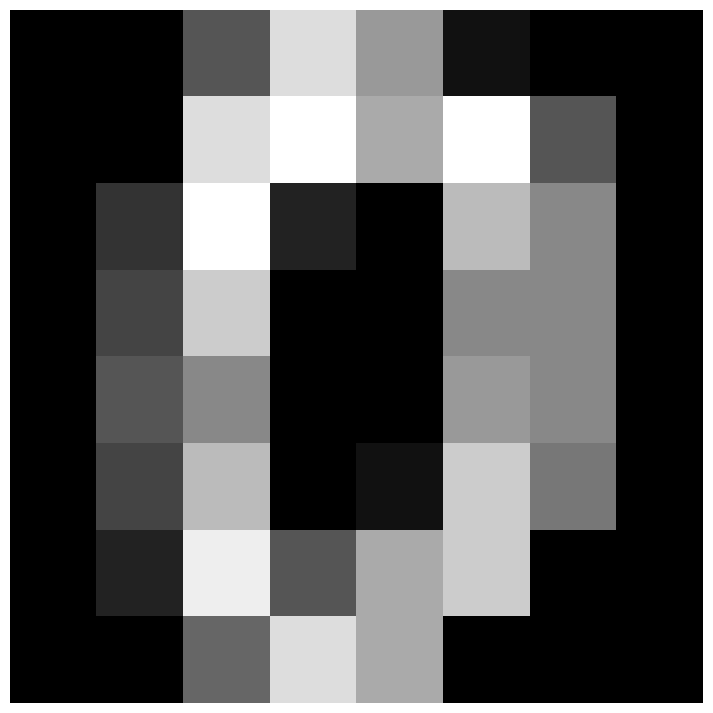

In [30]:
plt.imshow(X[0].reshape(8, 8).astype(int), cmap="gray")
plt.axis("off");

Работать будем с изображениями рукописных цифр. Тут все похоже на данные для 1 домашнего задания, каждая картинка представлена вектором из 64 элементов (числа от 0 до 255). Чтобы ее нарисовать мы должны сделать `reshape` в картинку 8 на 8 пикселей. Вам нужно будет выбрать наилучший способ кластеризации при помощи функции `algorithm_selection`, которую вы реализуете. Для некоторых метрик кластеризации требуются метки **классов** объектов (они хранятся в переменной `y`).

##### YOUR TURN TO CODE

In [38]:
# Some additional function to pass same arguments to several functions
def pass_args(*args, **kwargs):
    return lambda fun:fun(*args, **kwargs)

In [249]:
def select_algorithm(X, y = None, n = 10, distances=('euclidean', 'manhattan', 'l1', 'l2', 'canberra', 'jaccard'), 
                     algorithms = ('average', 'single', 'complete'), metrics = ('homogenity', 'completeness', 'v_measure', 'silhouette')):
    """
    Для заданных алгоримов кластеризации и гиперпараметров 
    считает различные метрики кластеризации
        :param X: наши данные (n_samples, n_features)
        :param distances: список возможных метрик расстояния
        :param algorithm: параметр linkage ('average', 'single', 'complete')
        :param metrics: список возможных метрик качества кластеризации
    :return compare_dataframe: таблица с метриками кластеризации
    """

    """
    YOUR CODE IS HERE #переименовал функцию чтобы название было более питонячем
    """
    column_names = ['distance', 'linkage', 'silhouette']
    if y is not None:
        column_names.extend(['homogenity', 'completeness', 'v_measure'])
        
    compare_dataframe = pd.DataFrame(columns = column_names)
    
    for dist in distances:
        for algo in algorithms:
            cluster_model = AgglomerativeClustering(n_clusters=n, affinity=dist, linkage=algo)
            y_pred = cluster_model.fit_predict(X)
            
            силуэт = silhouette_score(X, y_pred, metric=dist)
            metric_results =  [dist, algo, силуэт]
            
            if y is not None:
                other_metrics_results = tuple(map(pass_args(y, y_pred), 
                            [homogeneity_score, completeness_score, v_measure_score]))
                metric_results.extend(other_metrics_results)
            
            compare_dataframe.loc[len(compare_dataframe)] = metric_results

    
    return compare_dataframe

In [45]:
selection_scores = select_algorithm(X, y)
selection_scores.sort_values('silhouette', ascending=False)

distance   linkage  silhouette  homogenity  completeness  v_measure
5   manhattan  complete    0.160617    0.646372      0.686109   0.665648
8          l1  complete    0.160617    0.646372      0.686109   0.665648
0   euclidean   average    0.146625    0.655393      0.782342   0.713263
9          l2   average    0.146625    0.655393      0.782342   0.713263
2   euclidean  complete    0.119271    0.590549      0.637772   0.613253
11         l2  complete    0.119271    0.590549      0.637772   0.613253
12   canberra   average    0.108401    0.573860      0.779789   0.661161
3   manhattan   average    0.105238    0.566751      0.778942   0.656117
6          l1   average    0.105238    0.566751      0.778942   0.656117
14   canberra  complete    0.104411    0.528702      0.561588   0.544649
16    jaccard    single   -0.057100    0.005014      0.271451   0.009846
1   euclidean    single   -0.133621    0.005056      0.273755   0.009929
10         l2    single   -0.133621    0.005056      0.273755   0.009929
15    jaccard   average   -0.138812    0.026260      0.179269   0.045809
13   canberra    single   -0.157872    0.006144      0.280506   0.012025
17    jaccard  complete   -0.193811    0.103637      0.313725   0.155805
4   manhattan    single   -0.203816    0.005102      0.276237   0.010019
7          l1    single   -0.203816    0.005102      0.276237   0.010019

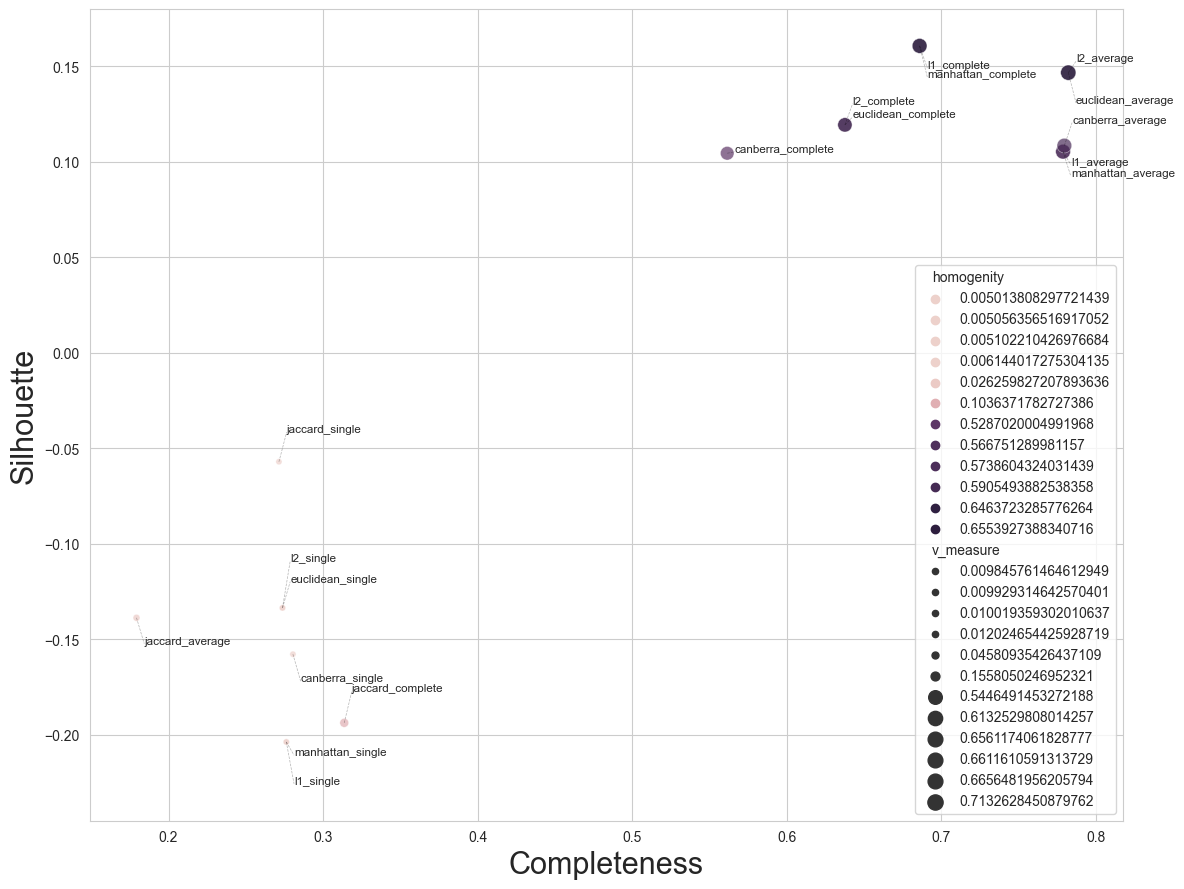

In [46]:
fig, ax = plt.subplots()

sns.scatterplot(data=selection_scores, x='completeness', y='silhouette', hue = 'homogenity',
            size='v_measure', sizes=(20, 120), legend="full", alpha=0.7)   
plt.xlabel('Completeness', fontsize=22)
plt.ylabel('Silhouette', fontsize=22)

np.random.seed(107)
for i, dist in enumerate(selection_scores.distance):
    x = selection_scores.completeness.loc[i]
    y =  selection_scores.silhouette.loc[i]
    x_text = selection_scores.completeness.loc[i] + 0.005
    y_text = selection_scores.silhouette.loc[i] + 0.001 + (np.random.rand()-0.5)/20
    plt.plot([x, x_text], [y, y_text], linestyle="--", linewidth=0.5, c='black', alpha=0.3)
    plt.text(x_text, y_text,
             f'{dist}_{selection_scores.linkage.loc[i]}', fontsize='small')

plt.tight_layout()

Определенно, из linkage лучше всего работает `average` и `complete`. Из метрик, кажется, лучшими по совокупности параметров можно назвать `l2`, `euclidian` и `manhattan`.

## Задание 3. Аннотация клеточных типов

суммарно 10 баллов

В этом задании вам предстоит применять полученные знания о кластеризации для аннотации данных, полученных при помощи проточной цитометрии. Каждая строка в данных это одна клетка, столбцы **FSC-A**, **SSC-A** косвенным образом свидетельствуют о размере клеток, остальные показывают интенсивность флуоресценции различных поверхностных маркеров. Ваша задача определить для каждой клетки, к какому типу она относится.

#### 3.1. EDA

1.5 балла

Проведите EDA:

1. Посмотрите на данные (можно попробовать метод `describe`)
2. Сколько у нас клеток / признаков
3. Постройте распределения каждого признака (есть ли очевинные выбросы?)

##### YOUR TURN TO CODE:

In [15]:
fc_data = pd.read_csv(join('data', "flow_c_data.csv"), index_col=0)

Крокодил, вид спереди

In [16]:
fc_data.head(3)

FSC-A     SSC-A    HLA-DR       CD3      CD45      CD14      CD56  \
0  0.722199  0.154232  0.494449  0.512853  4.057328  1.019255  4.007273   
1  0.751073  0.114618  4.671924  0.822042  4.933149  0.159388 -0.216407   
2  1.108188  0.150011 -0.422857  4.006353  5.616384  0.519223  0.783077   

       CD19     CD11c  
0 -1.406912  0.384406  
1  6.034845  0.577039  
2 -0.318668 -0.493832

Крокодил, вид сбоку

In [17]:
fc_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FSC-A   10000 non-null  float64
 1   SSC-A   10000 non-null  float64
 2   HLA-DR  10000 non-null  float64
 3   CD3     10000 non-null  float64
 4   CD45    10000 non-null  float64
 5   CD14    10000 non-null  float64
 6   CD56    10000 non-null  float64
 7   CD19    10000 non-null  float64
 8   CD11c   10000 non-null  float64
dtypes: float64(9)
memory usage: 781.2 KB


Имеем 10000 клеток, 8 признаков, 6 часов до дедлайна.

Крокодил, вид сзади

In [271]:
fc_data.describe()

FSC-A         SSC-A        HLA-DR           CD3          CD45  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.962458      0.165415      1.791579      3.280391      5.169845   
std        0.500012      0.190773      2.027281      2.112079      0.518247   
min        0.144786      0.021657     -7.634172     -2.517639     -8.329666   
25%        0.798804      0.105550      0.275056      1.401943      4.922227   
50%        0.908574      0.130543      1.194313      4.373660      5.234119   
75%        1.052034      0.162536      3.696976      4.842212      5.481218   
max       42.954485     15.460997     12.946668     13.844391     13.710922   

               CD14          CD56          CD19         CD11c  
count  10000.000000  10000.000000  10000.000000  10000.000000  
mean       1.097182      0.412223      1.219683      0.569898  
std        1.375876      1.176967      2.285305      1.502445  
min       -8.833883    -12.358701     -9.640775    -11.085437  
25%        0.389746     -0.195978     -0.146948     -0.498781  
50%        0.672853      0.053267      0.244121      0.272297  
75%        1.065076      0.378576      0.908374      1.220576  
max        6.294236      6.461899      7.208721      6.840864

Первая колонка вкупе с boxplot ниже показывает, что  есть потенциальные выборсы. Уберем их.

Text(0.5, 1.0, 'Data with removed outlier')

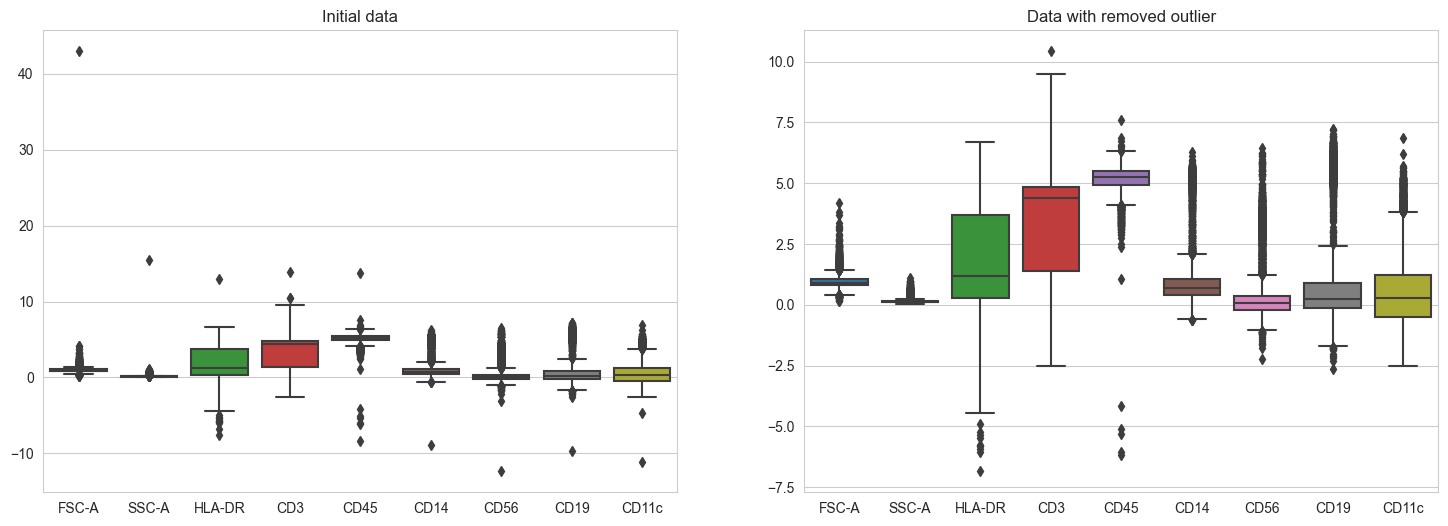

In [272]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.boxplot(fc_data, ax=axes[0])
axes[0].set_title('Initial data')

fc_data_clean = fc_data.drop(labels=[np.argmax(fc_data['FSC-A']), 
                                     np.argmax(fc_data['CD3']), 
                                     np.argmin(fc_data['CD14']),
                                     np.argmin(fc_data['CD56']),
                                     np.argmin(fc_data['CD45'])], axis=0, inplace=False)
sns.boxplot(fc_data_clean, ax=axes[1])
axes[1].set_title('Data with removed outlier')

<AxesSubplot: >

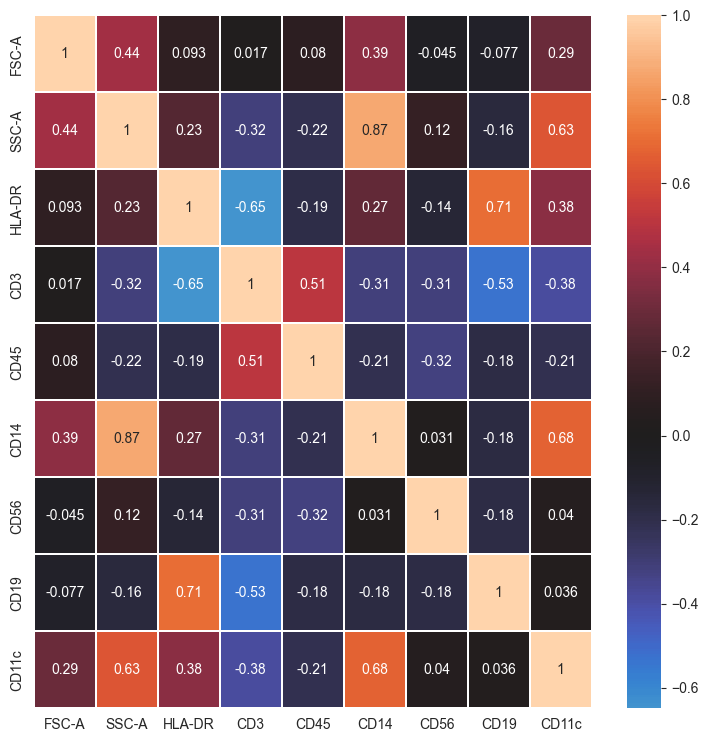

In [273]:
fig, axes = plt.subplots(figsize=(9, 9))
corr = fc_data_clean.corr()
sns.heatmap(corr, center=0,linewidths=.1, annot = True)

#### 3.2. Кластеризация

4.5 балла

При ручной аннотации клеточных типов обычно поступают следующим образом:

1. При помощи методов понижения размерности рисуют наши наблюдения, чтобы примерно оценить число клеточных типов
2. Проводят кластеризацию наблюдений (для некоторых методов нужно заранее задать число кластеров, поэтому нам как раз помогает п.1)
3. Далее мы считаем, что клетки, которые алгоритм отнес к одному кластеру являются одним клеточным типом (если кластеров больше, чем типов клеток, то возможно, что 2 разных кластера являются одним типом)
4. После чего по интенсивности экспрессии поверхностных маркеров мы присваиваем кластеру клеточный тип

Давайте для начала напишем удобную функцию для визуализации наших многомерных данных в пространстве размерностью 2, делать мы это будем при помощи алгоритма t-SNE.

Поиграться с красивой визуализацией можно [тут](https://distill.pub/2016/misread-tsne/).

In [242]:
def plot_tsne(data, n_iter=1000, 
              perplexity=40, color=None):
    """
    Функция для отрисовки результатов работы t-SNE
        :param data: таблица объекты х признаки
        :param n_iter: число итераций градиентного спуска,
            может быть полезно увеличить, чтобы получить результаты получше
        :param perplexity: 
        :param color: np.array[n_samples] с переменной,
            которой мы хотим покрасить наши наблюдения
        :return tsne_emb: np.array[n_samples, 2] - результаты работы t-SNE
    """
    
    # Сначала сделаем PCA, так как это хорошее начальное приближение для t-SNE
    # позволит алгоритму быстрее сойтись
    pca = PCA().fit(data)
    pca_embedding = pca.transform(data)
    
    # Запустим t-SNE, он выдаст нам для каждого объекта по 2 числа, 
    # которые мы сможем нарисовать
    tnse = TSNE(n_components=2, init=pca_embedding[:, :2], n_jobs=-1,
                n_iter=n_iter, perplexity=perplexity)
    tsne_embedding = tnse.fit_transform(pca_embedding)
    
    sns.scatterplot(x=tsne_embedding[:, 0],
                    y=tsne_embedding[:, 1],
                    hue=color, palette="colorblind")
    plt.xlabel("$TSNE_1$", fontsize=18)
    plt.ylabel("$TSNE_2$", fontsize=18)
    
    # Вернем также результаты t-SNE, так как, если потом захотим перестроить картинку,
    # в таком случае нам не придется ждать заново, просто нарисуем новую с готовыми данными
    
    return tsne_embedding

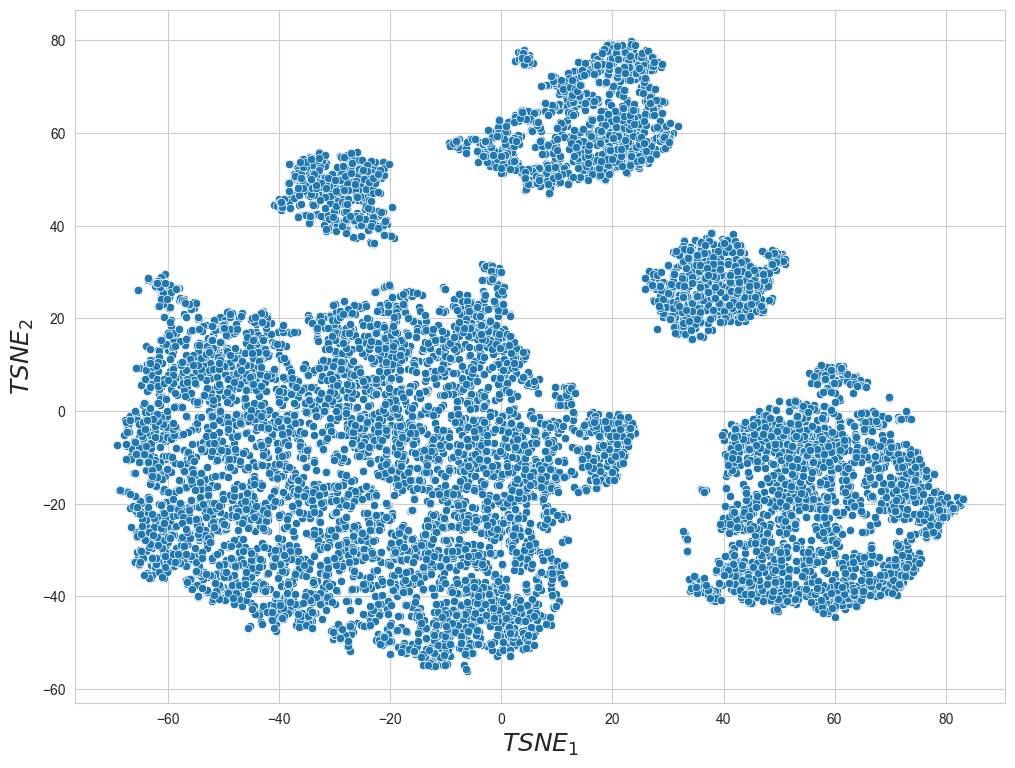

In [262]:
tsne_res = plot_tsne(fc_data_clean)

Кластеризуйте ваши данные:

1. Попробуйте методы кластеризации из тех, что мы прошли
2. Выберите лучший на основании метрики `silhouette_score` (попробуйте также подобрать гиперпараметры)
3. Присвойте каждому наблюдению метку класса и нарисуйте график t-SNE, покрасив точки метками кластера

> **My K-Means**

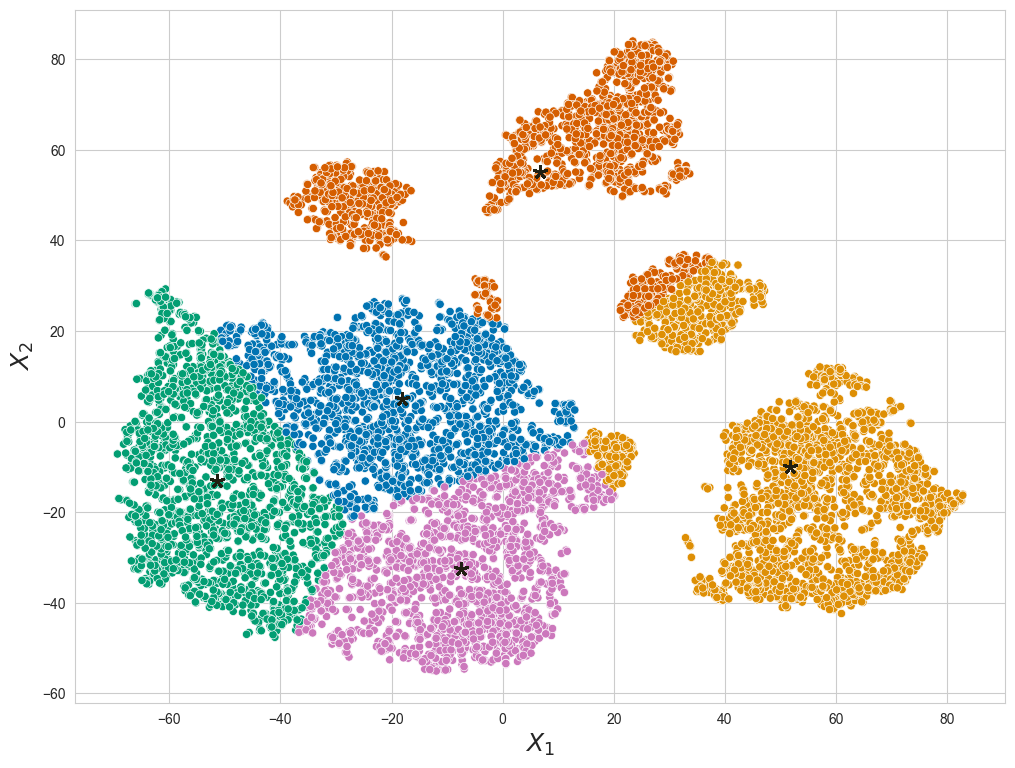

0.19689890677371955

In [52]:
mkm_sample = MyKMeans(5, init="sample", max_iter=5, visualize=True, speed=0.001)
mkm_sample.fit(tsne_res)
mkm_pred = mkm_sample.predict(tsne_res)
silhouette_score(fc_data_clean, mkm_pred)

> **Agglomaretive Clustering**

In [243]:
cell_types_clust_scores_ac = select_algorithm(fc_data_clean, metrics='silhouette', n=5)

In [244]:
cell_types_clust_scores_ac.sort_values('silhouette', ascending=False).head()

distance   linkage  silhouette
3  manhattan   average    0.617335
6         l1   average    0.617335
0  euclidean   average    0.606850
9         l2   average    0.606850
5  manhattan  complete    0.595043

На основе метрики силуэт можно сказать, что для иерархической кластеризации на наших данных лучше всего брать метрику `manhattan/l1` с `single/average` linkage.  

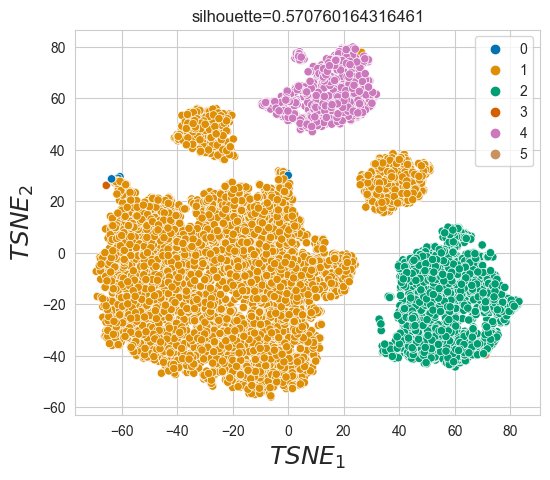

In [246]:
aggc = AgglomerativeClustering(n_clusters=6, affinity='l1', linkage='average')
predicted_aggc = aggc.fit_predict(fc_data_clean)
силуэт = silhouette_score(fc_data_clean, predicted_aggc)

plt.figure(figsize=(6,5))
plt.title(f'silhouette={силуэт}')
tsne_res_ac = plot_tsne(fc_data_clean, color=predicted_aggc)

Мы можем чуть приблизиться к нашим ожиданиям с использованием косинусного расстояния, однако силуэт будет меньше.

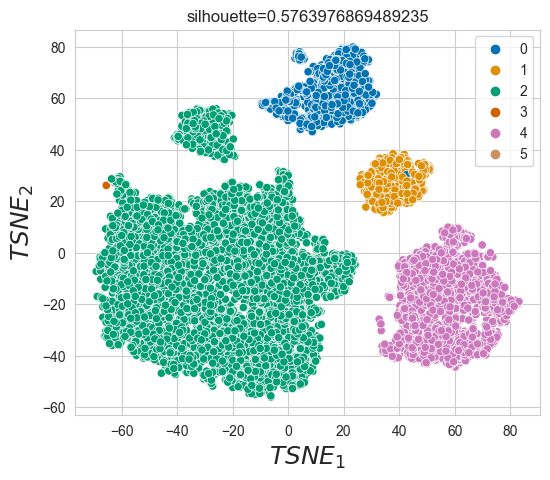

In [248]:
aggc = AgglomerativeClustering(n_clusters=6, affinity='cosine', linkage='average')
predicted_aggc = aggc.fit_predict(fc_data_clean)
силуэт = silhouette_score(fc_data_clean, predicted_aggc)

plt.figure(figsize=(6,5))
plt.title(f'silhouette={силуэт}')
tsne_res_ac = plot_tsne(fc_data_clean, color=predicted_aggc)

> **DBSCAN**

In [254]:
def select_dbscan(X, epsilons = [2, 3, 4, 7],
                  algorithms = ['auto', 'ball_tree', 'kd_tree', 'brute'], 
                  distances=('manhattan', 'euclidean')):
    
    column_names = ['epsilon', 'algorithms', 'metric', 'silhouette']
    compare_dataframe = pd.DataFrame(columns = column_names)
    
    for dist in distances:
        for eps in epsilons:
            for algo in algorithms:
                cluster_model = DBSCAN(eps=eps, min_samples=5, algorithm=algo, metric=dist, n_jobs=-1)
                y_pred = cluster_model.fit_predict(X)
                силуэт = silhouette_score(X, y_pred, metric=dist)
                compare_dataframe.loc[len(compare_dataframe)] = [eps, algo, dist, силуэт]

    
    return compare_dataframe

In [255]:
cell_types_clust_scores_dbs = select_dbscan(fc_data_clean)
cell_types_clust_scores_dbs.sort_values('silhouette', ascending=False).head(10)

epsilon algorithms     metric  silhouette
31        7      brute  euclidean    0.654651
30        7    kd_tree  euclidean    0.654651
29        7  ball_tree  euclidean    0.654651
28        7       auto  euclidean    0.654651
27        4      brute  euclidean    0.654651
26        4    kd_tree  euclidean    0.654651
25        4  ball_tree  euclidean    0.654651
24        4       auto  euclidean    0.654651
13        7  ball_tree  manhattan    0.631553
15        7      brute  manhattan    0.631553

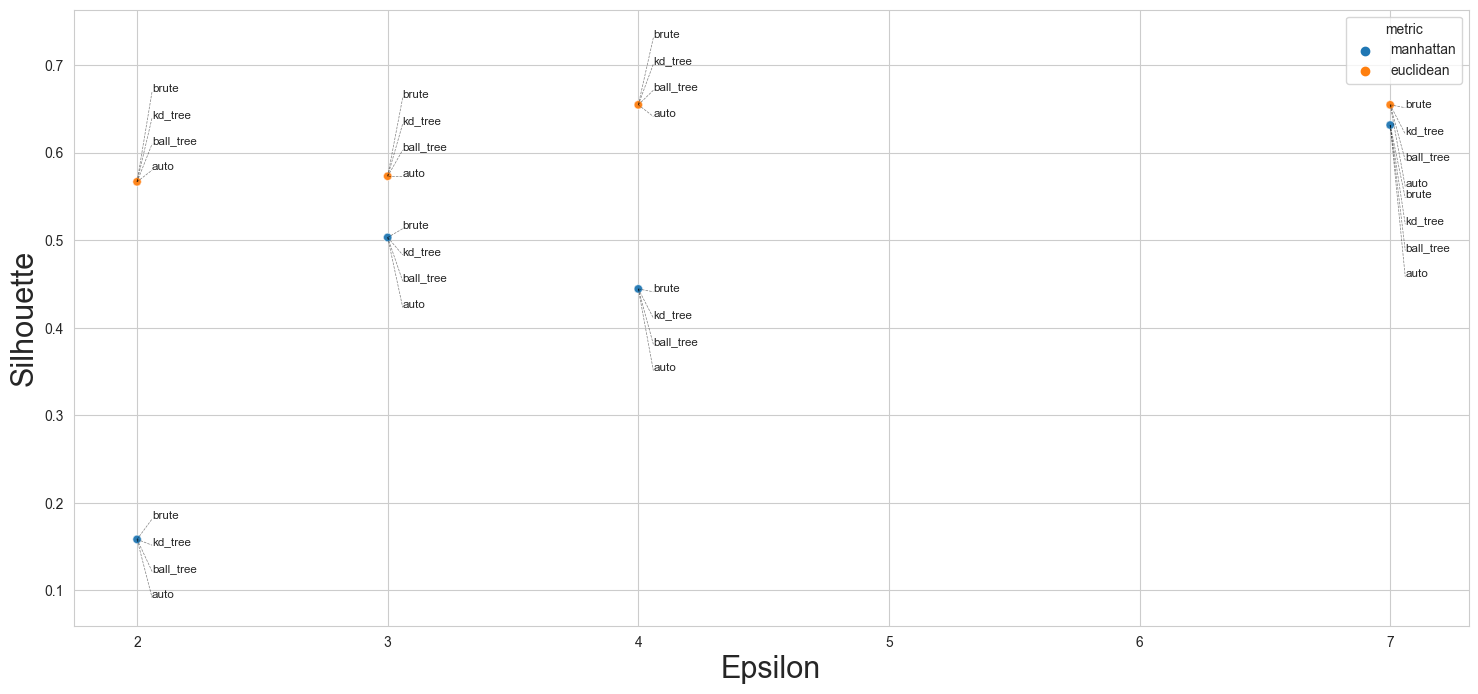

In [256]:
fig, ax = plt.subplots(figsize=(18, 8))

sns.scatterplot(data=cell_types_clust_scores_dbs, x='epsilon', y='silhouette', 
                hue='metric', legend="full", alpha=0.5)   
plt.xlabel('Epsilon', fontsize=22)
plt.ylabel('Silhouette', fontsize=22)

for i, algo in enumerate(cell_types_clust_scores_dbs.algorithms):
    x = cell_types_clust_scores_dbs.epsilon.loc[i]
    y =  cell_types_clust_scores_dbs.silhouette.loc[i]
    x_text = cell_types_clust_scores_dbs.epsilon.loc[i] + 0.06
    y_text = cell_types_clust_scores_dbs.silhouette.loc[i] + i%4/40 + i/200 - x/30 
    plt.plot([x, x_text], [y, y_text], linestyle="--", linewidth=0.5, c='black', alpha=0.5)
    plt.text(x_text, y_text, f'{algo}', fontsize='small')

Как видим, от алгоритма ничего не зависит, ключевым является гиперпараметр ε. Лучше всего если равен 4 c евклидовой метрикой.

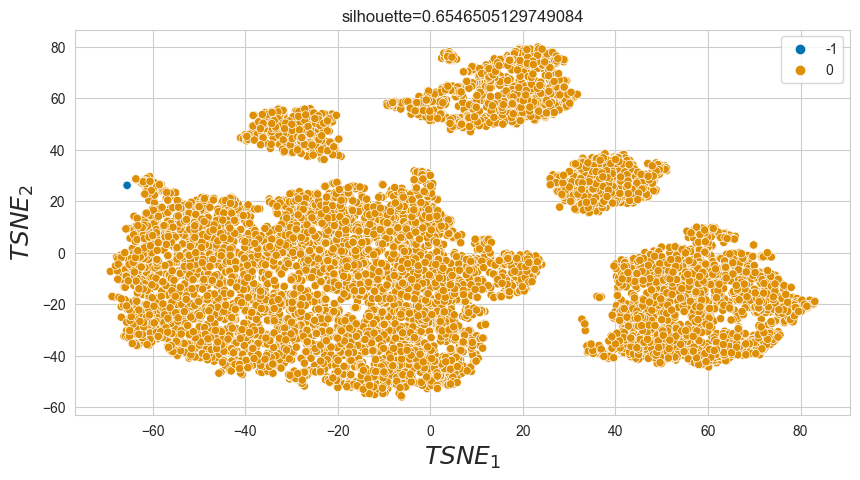

In [257]:
dbscan = DBSCAN(eps=4, min_samples=5, algorithm='auto', metric='euclidean', n_jobs=12)
predicted_dbscan = dbscan.fit_predict(fc_data_clean)
силуэт = silhouette_score(fc_data_clean, predicted_dbscan)

plt.figure(figsize=(10,5))
plt.title(f'silhouette={силуэт}')
tsne_res_db = plot_tsne(fc_data_clean, color=predicted_dbscan)

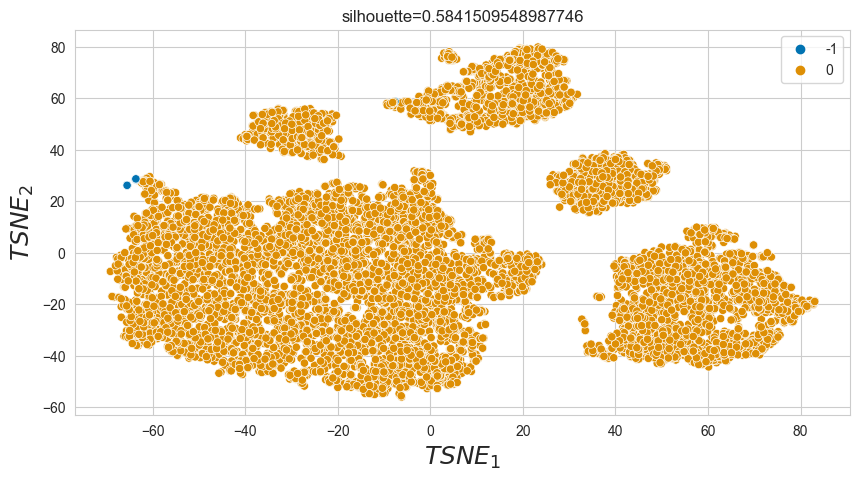

In [260]:
dbscan = DBSCAN(eps=4, min_samples=300, algorithm='auto', metric='euclidean', n_jobs=-1)
predicted_dbscan = dbscan.fit_predict(fc_data_clean)
силуэт = silhouette_score(fc_data_clean, predicted_dbscan)

plt.figure(figsize=(10,5))
plt.title(f'silhouette={силуэт}')
tsne_res_db = plot_tsne(fc_data_clean, color=predicted_dbscan)

> **KMeans**

In [285]:
def select_kmeans(X, n_clusters = [2, 3, 4, 8, 9],
                  algorithms =["lloyd", "elkan"]):
    
    column_names = ['n_clusters', 'algorithms', 'silhouette']
    compare_dataframe = pd.DataFrame(columns = column_names)
    
    for n in n_clusters:
        for algo in algorithms:
            cluster_model = KMeans(n_clusters=n, algorithm=algo)
            y_pred = cluster_model.fit_predict(X)
            силуэт = silhouette_score(X, y_pred)
            compare_dataframe.loc[len(compare_dataframe)] = [n, algo, силуэт]

    
    return compare_dataframe

In [286]:
cell_types_clust_scores_kmeans = select_kmeans(fc_data_clean)
cell_types_clust_scores_kmeans.sort_values('silhouette', ascending=False).head(10)

n_clusters algorithms  silhouette
4           4      lloyd    0.611401
5           4      elkan    0.611401
2           3      lloyd    0.609757
3           3      elkan    0.609757
0           2      lloyd    0.537872
1           2      elkan    0.537872
8           9      lloyd    0.277977
6           8      lloyd    0.269337
9           9      elkan    0.268699
7           8      elkan    0.267309

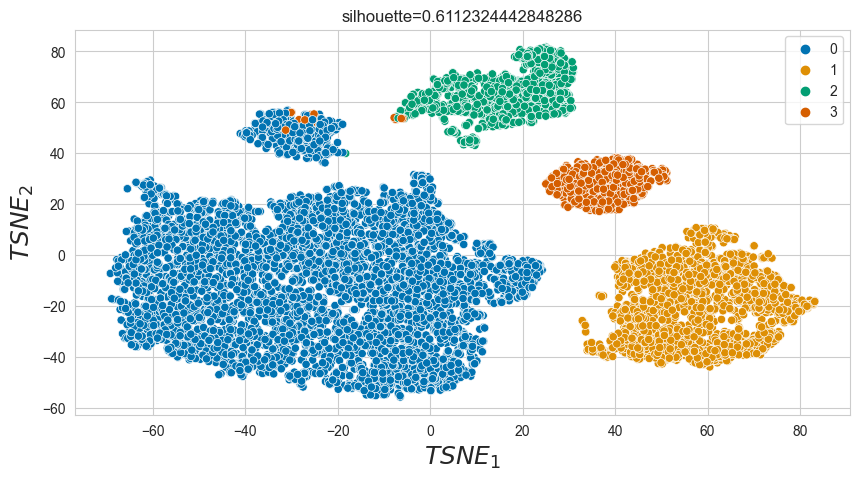

In [289]:
kmeans = KMeans(4, algorithm='lloyd')
predicted_kmeans = kmeans.fit_predict(fc_data_clean)
силуэт = silhouette_score(fc_data_clean, predicted_kmeans)

plt.figure(figsize=(6,5))
plt.title(f'silhouette={силуэт}')
tsne_res_db = plot_tsne(fc_data_clean, color=predicted_kmeans)

Удалось ли вам получить ситуацию, где отдельные группы точек покрашены в один цвет?

Со всеми 5 группами - нет. Опробованные алгоритмы вытаскивают какие-то другие зависимости из данных нежели t-SNE который мы используем для визуализации. Тем не менее, последний вариант был  одним из близки с неплохим силуэтом:

#### 3.3. Аннотация клеточных типов

4 балла

Теперь когда мы подобрали хороший алгоритм кластеризации, можно аннотировать наши клетки. Для этого мы нарисуем t-SNE и покрасим точки в зависимости от интенсивности экспрессии поверхностных маркеров. В датасете присутствуют следующие типы клеток:

* B_cells
* T_cells
* Monocytes
* Other cells

Вам нужно будет выяснить, какие клетки экспрессируют определенные маркеры и присвоить каждому кластеру один из типов клеток.

Для начала нарисуем все это безобразие:

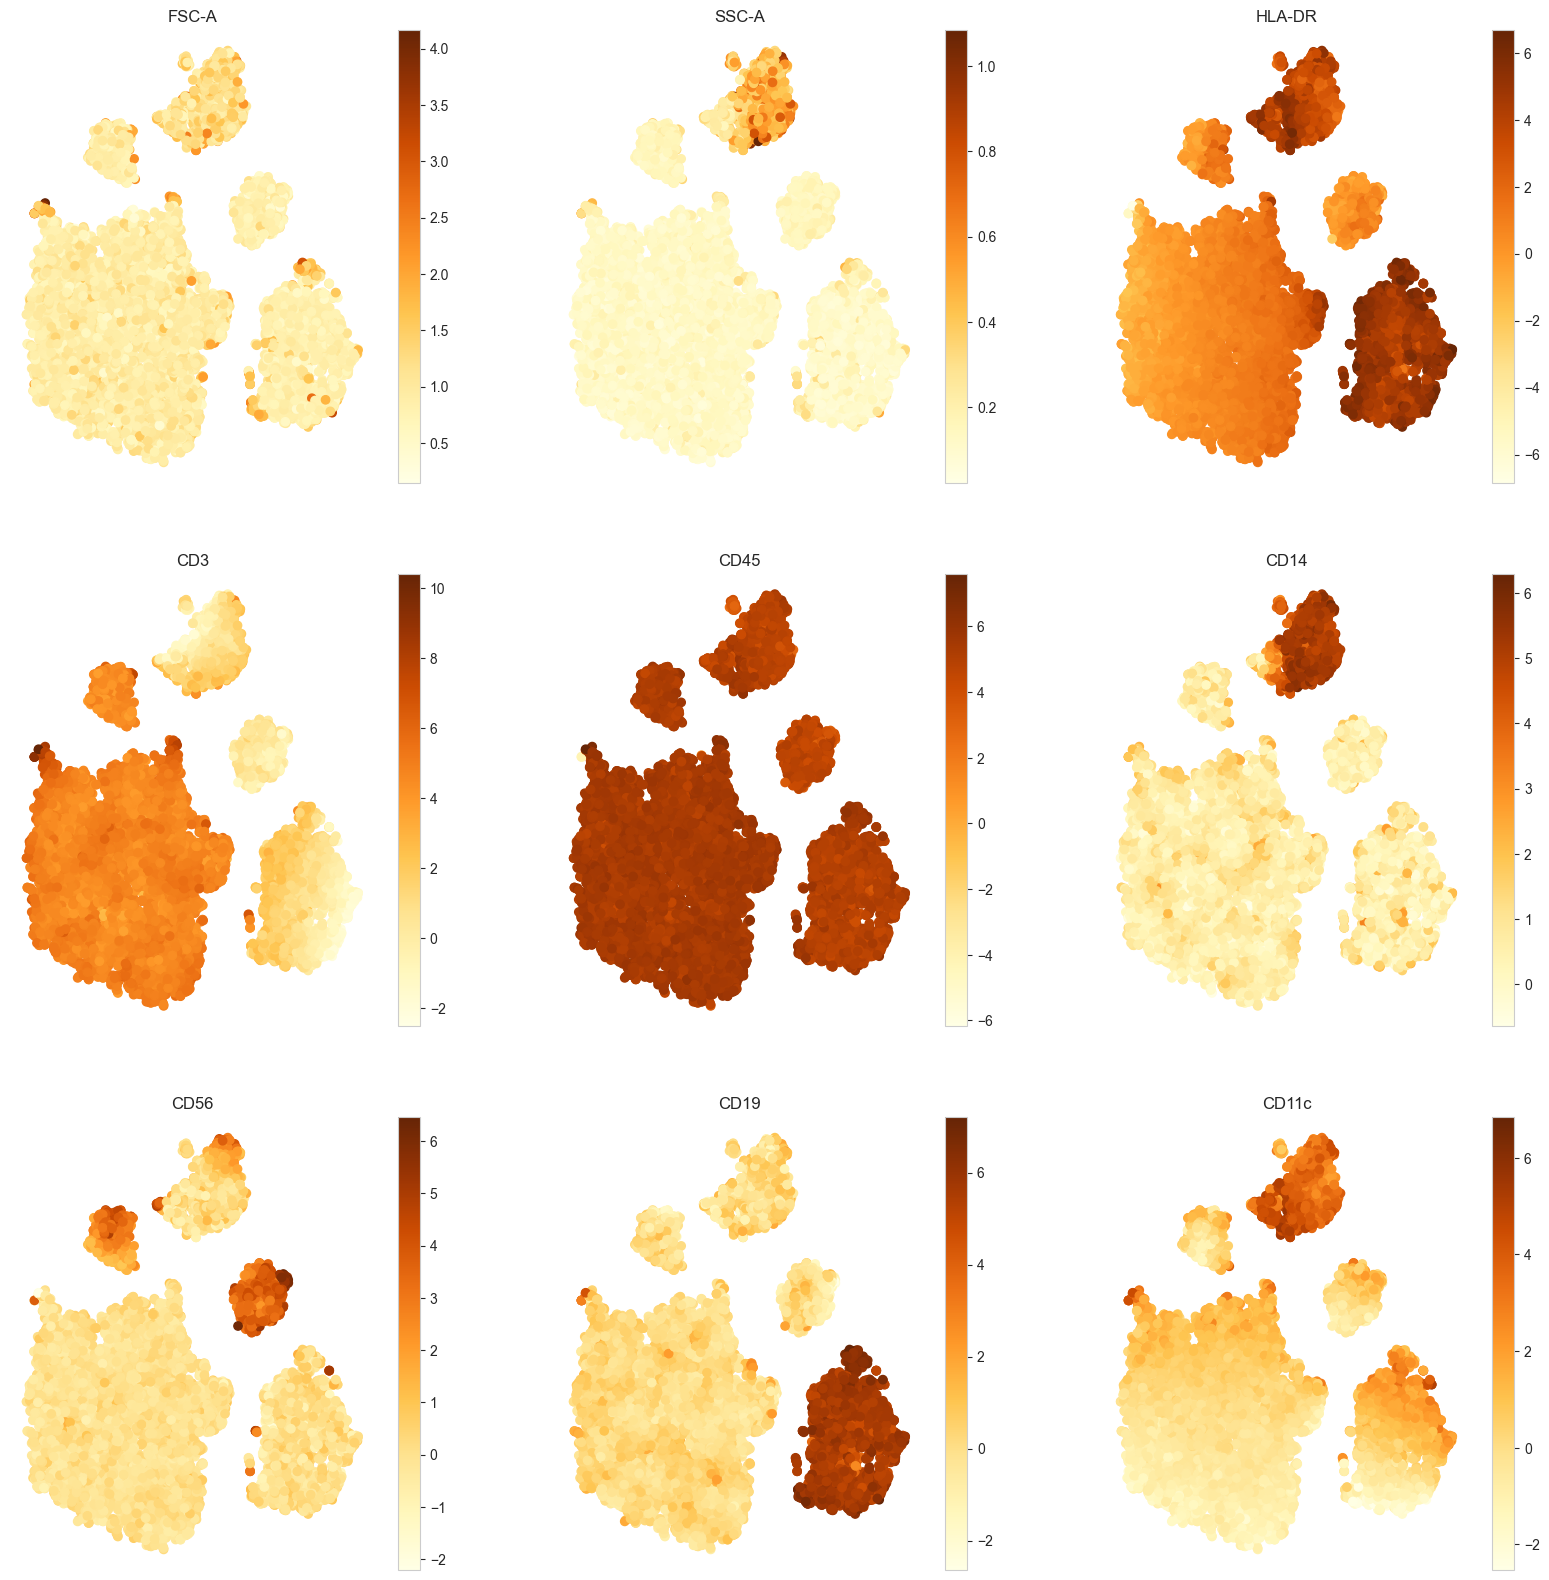

In [274]:
# Результаты t-SNE уже есть в переменной tsne_res
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for col, ax in zip(fc_data_clean.columns, axes.ravel()):
    scatter = ax.scatter(tsne_res[:, 0], tsne_res[:, 1], 
                         c=fc_data_clean[col], cmap="YlOrBr")
    fig.colorbar(scatter, ax=ax)
    ax.set_title(col)
    ax.grid(False)
    ax.axis("off")

Дальше дело за вами, нужно определить клеточный тип для каждого кластера и записать их как значения в словаре:

In [290]:
cell_type_cluster_map = {0: "T_cells",  #CD3
                         1: "B_cells",  #CD19
                         2: "Monocytes", # CD11c, CD14
                         3: "Other cells"}

In [291]:
labeled_fc_data = fc_data_clean.assign(Population=kmeans.labels_)
labeled_fc_data["Population"] = labeled_fc_data["Population"].map(cell_type_cluster_map)

Посчитайте, как распределены типы клеток:

In [292]:
labeled_fc_data.Population.value_counts()

T_cells        6199
B_cells        2035
Monocytes      1091
Other cells     673
Name: Population, dtype: int64

Сохраните ваши результаты в csv файл, мы сравним их с правильными ответами по метрике `f1_score(average="macro")`, которая хорошо подходит, даже если классы не сбалансированы.

In [331]:
outliers = [np.argmax(fc_data['FSC-A']), np.argmax(fc_data['CD3']), np.argmin(fc_data['CD14']),
            np.argmin(fc_data['CD56']), np.argmin(fc_data['CD45'])]

fc_outliers = fc_data.loc[set(outliers)]
fc_outliers['Population'] = None
labeled_fc_data = pd.concat([fc_outliers, labeled_fc_data]).sort_index()

In [332]:
labeled_fc_data.to_csv(join('data', "labeled_fc_data.csv"))

#### 3.4. Атоматическая аннотация

**дополнительные** 5 баллов

Это задание является дополнительным. Вам нужно построить классификатор клеточных типов на основе размеченных вами данных. Пока что мы прошли не так много разных классификаторов, но уже есть из чего выбирать.

Оцените качество полученной модели при помощи `f1_score(average="macro")`. Попробуйте его улучшить, каким-то образом поработав с дисбалансом классов ([помощь](https://elitedatascience.com/imbalanced-classes)).

### Задание 4. Любимое место

дополнительно 0.5 балла

Расскажите о вашем любимом месте, куда бы вы хотели съездить этой весной, если вы уже там бывали, то прикрепите фотографию)

Этой весной я бы хотел съездить в Ереван....

А любимое место - Сколтех!  Все для людей. Оч красивое. Особенно в тумане:

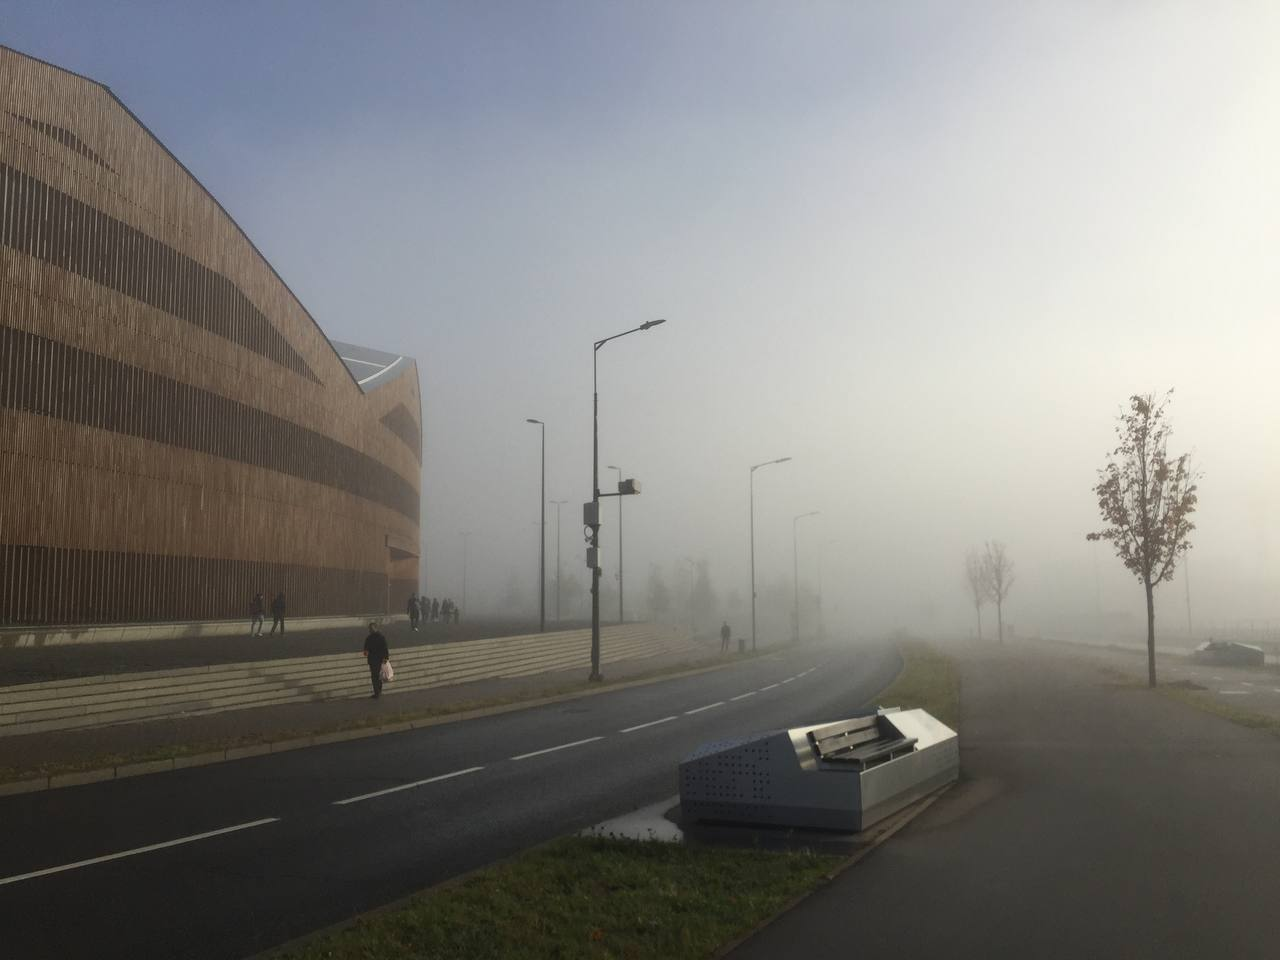

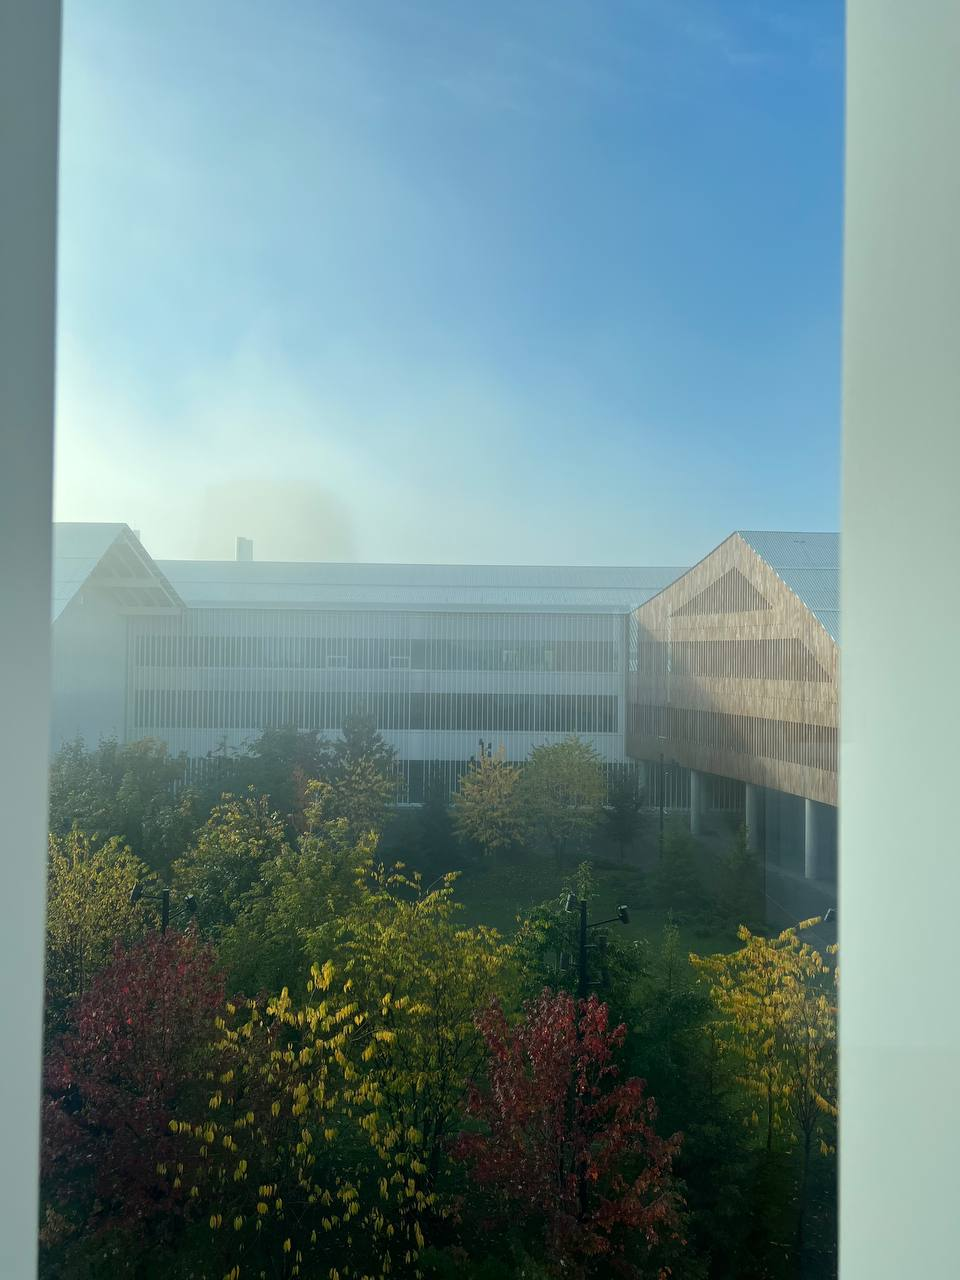

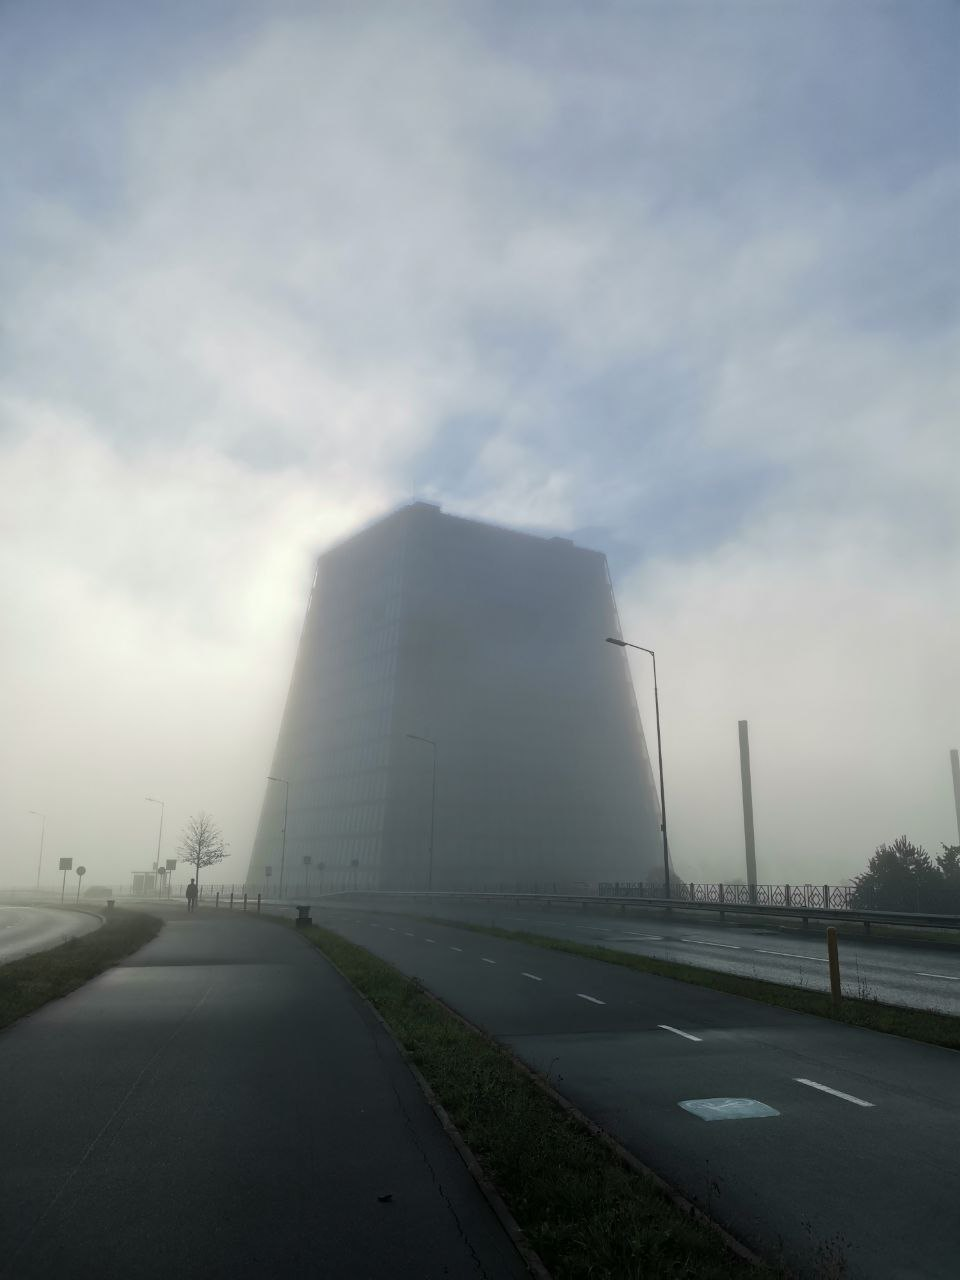

### Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**